The notebook is used for preparing the input and output files for:
1. Calibration
2. Validation

The following data is acquired from https://data.tpdc.ac.cn/en/data/0fbc30a8-6065-4be3-b98b-95ae7f15a69e/

- The datasets from 2016 - 2020 is considered for the analysis. 2020 - 2021 is not considered for the analysis since it contains missing data for nearly 3 months (2020-02 : 2020-05).
- From 2016 - 2019 is considered for calibration and 2019 - 2020 is considered for validation.
- This is considered only for the Case 1 (with sub_temp_0.0cm) and Case 5 (with SEB)
- Note: We need snow depth dataset for later years! (Not just 2017)

Steps taken for the analysis:
1. Missing data is identified
2. The missing data is imputed with datasets from the previous year
3. Stored as .h5 file

Further details are provided in the excel sheet - Available_data - 

- Final_data_excelsheet/AWS_Yakou_ITP_Data_2015,16,17,18,19,20 (Sheet name)

- Begin with the 2019 dataset as the initial conditions for the model.  

The excel sheet contains the following parameters:

1. Wind speed at 10 m
2. Wind direction at 10 m
3. Air temperature at 5 m 
4. Relative humidity at 5 m 
5. Precipitation at 10 m
6. Air pressure 
7. Infrared temperature 
8. Incoming shortwave radiation
9. Outgoing shortwave radiation
10. Incoming longwave radiation
11. Outgoing longwave radiation
12. Net radiation
13. Soil heat flux at - 0.06 m
14. Soil moisture at - 0.04 m, 0.1 m, 0.2 m, 0.4 m, 0.8 m, 1.2 m, 1.6 m
15. Soil temperature - 0.00 m, 0.04 m, 0.1 m, 0.2 m, 0.4 m, 0.8 m, 1.2 m, 1.6 m
16. Snow depth 

**The following notebook is an attempt to write the code concisely to extract all the datasets**

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec
import h5py
import os

In [2]:
sns.set()

In [3]:
print(os.getcwd())

/home/rk/Article_1/1_data_prep


In [4]:
pd.set_option('display.max_columns',85)
pd.set_option('display.max_rows',100)

### 1. Reading the data

In [5]:
### Reading the data
df_AWS_2015 = pd.read_excel('Final_data_excelsheet/AWS_Yakou_ITP_Data_2015.xlsx',index_col=0,parse_dates=True)  
df_AWS_2016 = pd.read_excel('Final_data_excelsheet/AWS_Yakou_ITP_Data_2016.xlsx',index_col=0,parse_dates=True)
df_AWS_2017 = pd.read_excel('Final_data_excelsheet/AWS_Yakou_ITP_Data_2017.xlsx',index_col=0,parse_dates=True)
df_AWS_2018 = pd.read_excel('Final_data_excelsheet/AWS_Yakou_ITP_Data_2018.xlsx',index_col=0,parse_dates=True)
df_AWS_2019 = pd.read_excel('Final_data_excelsheet/AWS_Yakou_ITP_Data_2019.xlsx',index_col=0,parse_dates=True)
df_AWS_2020 = pd.read_excel('Final_data_excelsheet/AWS_Yakou_ITP_Data_2020.xlsx',index_col=0,parse_dates=True)

In [6]:
### Merging the data - https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# Combining the dataset into a single dataframe
frames = [df_AWS_2015, df_AWS_2016, df_AWS_2017, df_AWS_2018, df_AWS_2019, df_AWS_2020]
df_AWS = pd.concat(frames)
df_AWS.head()

,WS_10m,WD_10m,Ta_5m,RH_5m,Rain,Press,IRT_1,IRT_2,PAR_down,PAR_up,DR,UR,DLR_Cor,ULR_Cor,Rn,Gs_1,Gs_2,Gs_3,Ms_4cm,Ms_10cm,Ms_20cm,Ms_40cm,Ms_80cm,Ms_120cm,Ms_160cm,Ts_0cm,Ts_4cm,Ts_10cm,Ts_20cm,Ts_40cm,Ts_80cm,Ts_120cm,Ts_160cm
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-09-18 12:40:00,4.114,195.0,1.872,79.55,0.0,619.5,10.720,10.510,136.60,15.390,761.7,122.90,257.7,385.9,510.7,1.851,27.56,41.13,40.85,37.72,39.97,37.92,15.63,11.89,23.02,11.170,3.927,2.504,2.547,3.001,1.803,0.402,0.075
2015-09-18 12:50:00,4.746,186.5,1.740,79.02,0.0,619.6,8.170,8.240,69.70,7.617,376.6,52.88,267.1,383.3,207.5,3.026,31.32,45.79,40.87,37.72,39.98,37.91,15.63,11.89,23.02,9.870,4.167,2.582,2.559,2.993,1.804,0.402,0.075
2015-09-18 13:00:00,5.071,198.9,1.463,80.40,0.0,619.6,6.084,5.969,49.68,5.490,249.2,32.05,300.3,377.3,140.2,4.481,34.92,49.90,40.86,37.73,39.97,37.91,15.64,11.89,23.04,7.719,4.416,2.675,2.574,2.983,1.802,0.405,0.074
2015-09-18 13:10:00,5.515,204.3,1.165,80.20,0.0,619.5,5.530,5.373,53.82,5.889,273.2,32.05,277.8,374.0,145.0,6.054,35.88,49.80,40.87,37.72,39.98,37.90,15.64,11.90,23.06,7.007,4.564,2.775,2.590,2.972,1.801,0.405,0.078
2015-09-18 13:20:00,5.155,200.4,0.973,83.60,0.0,619.4,5.312,5.153,50.15,5.453,234.0,32.05,306.3,372.8,135.4,7.647,34.43,46.08,40.87,37.72,39.97,37.90,15.64,11.90,23.07,6.489,4.618,2.880,2.610,2.965,1.799,0.405,0.080


In [7]:
### Details about the AWS met data
df_AWS_details = pd.read_excel('Available_data.xlsx', sheet_name='AWS_Yakou_ITP_Data_2019_extract',index_col=0,parse_dates=True)  
df_AWS_details.head()

,Parameter,Product Name & Direction,Variable name,Depth/Height [m],Time steps [mins],Time interval,Units,Comments
Sl.No.,,,,,,,,
1,Wind speed at 10 m (m/s),"010C/020C; 10 m, north",WS_10m,10.0,10,01.01.2019 00:00 - 31.12.2019 23:50,m/s,NaN
2,Wind direction at 10 m (°),"010C/020C; 10 m, north",WD_10m,10.0,10,01.01.2019 00:00 - 31.12.2019 23:50,°,Why is the data all red?
3,Air temperature at 5 m (°C),"HMP45C; 5 m, north",Ta_5m,5.0,10,01.01.2019 00:00 - 31.12.2019 23:50,°C,NaN
4,Relative humidity at 5 m (%),"HMP45C; 5 m, north",RH_5m,5.0,10,01.01.2019 00:00 - 31.12.2019 23:50,%,Is it relative? Says RH - Hence should be rela...
5,Precipitation at 10 m (mm),rain gauge (TE525M; 10 m),Rain,10.0,10,01.01.2019 00:00 - 31.12.2019 23:50,mm,Precipitation measurement at 10 m? Seems odd


In [8]:
### Renaming the columns - 
data_AWS = df_AWS.copy()
data_AWS.columns = df_AWS_details['Parameter'].values
data_AWS.columns

Index(['Wind speed at 10 m (m/s)', 'Wind direction at 10 m (°)',
       'Air temperature at 5 m (°C)', 'Relative humidity at 5 m (%)',
       'Precipitation at 10 m (mm)', 'Air pressure (hPa)',
       'Infrared temperature (°C)', 'Infrared temperature (°C)', 'PAR_down',
       'PAR_up', 'Incoming shortwave radiation (W/m^2)',
       'Outgoing shortwave radiation (W/m^2)',
       'Incoming longwave radiation (W/m^2)',
       'Outgoing longwave radiation (W/m^2)', 'Net radiation (W/m^2)',
       'Soil heat flux at - 0.06 m (W/m^2) - 1',
       'Soil heat flux at - 0.06 m (W/m^2) - 2',
       'Soil heat flux at - 0.06 m (W/m^2) - 3',
       'Soil moisture at - 0.04 m (%)', 'Soil moisture at - 0.1 m (%)',
       'Soil moisture at - 0.2 m (%)', 'Soil moisture at - 0.4 m (%)',
       'Soil moisture at - 0.8 m (%)', 'Soil moisture at - 1.2 m (%)',
       'Soil moisture at - 1.6 m (%)', 'Soil temperature at - 0.00 m (°C)',
       'Soil temperature at - 0.04 m (°C)', 'Soil temperature at - 0.1 

### 2. Dealing with NaN, Erroneous, and missing data

#### 2.a. Data has -6999 values for missing data - hence replacing -6999 with NaN values

In [9]:
data_AWS_syn = data_AWS.copy()
data_AWS_syn = data_AWS_syn.replace(-6999,None)

In [10]:
data_AWS_prep = data_AWS_syn.copy()

In [11]:
### Check for NaN values
data_AWS_syn.index[np.where(np.isnan(data_AWS_syn))[0]]

DatetimeIndex([       '2018-04-20 14:00:00',        '2018-04-20 14:10:00',
                      '2018-05-05 14:30:00', '2018-12-10 08:39:59.995000',
               '2018-12-10 09:19:59.995000', '2018-12-10 09:29:59.995000',
                      '2019-01-22 07:30:00',        '2019-01-30 17:30:00',
                      '2019-01-30 21:00:00',        '2019-01-31 00:40:00',
               ...
               '2020-12-31 16:09:59.980000', '2020-12-31 16:19:59.980000',
               '2020-12-31 16:29:59.980000', '2020-12-31 16:39:59.980000',
               '2020-12-31 16:49:59.980000', '2020-12-31 16:59:59.980000',
               '2020-12-31 17:09:59.980000', '2020-12-31 17:19:59.980000',
               '2020-12-31 17:29:59.980000', '2020-12-31 17:39:59.980000'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=40078, freq=None)

**Comments**:
* Few NaN values are present (278132/9178356 = 3.03% ). Since the data is available every 10 mins, we have considered to resample the data.

### 3. Resampling the data to daily mean values

In [12]:
data_AWS_syn = data_AWS_syn.resample('D').mean()

# Precipitation - Daily summation of the values are determined instead of mean

data_AWS_prep_dailysum = data_AWS_prep['Precipitation at 10 m (mm)'].resample('D').sum()

## Working with first the input data 
- Wind speed at 10 m, Air temperature at 5 m, Relative humidity at 5 m, Precipitation at 10 m, Incoming shortwave radiation

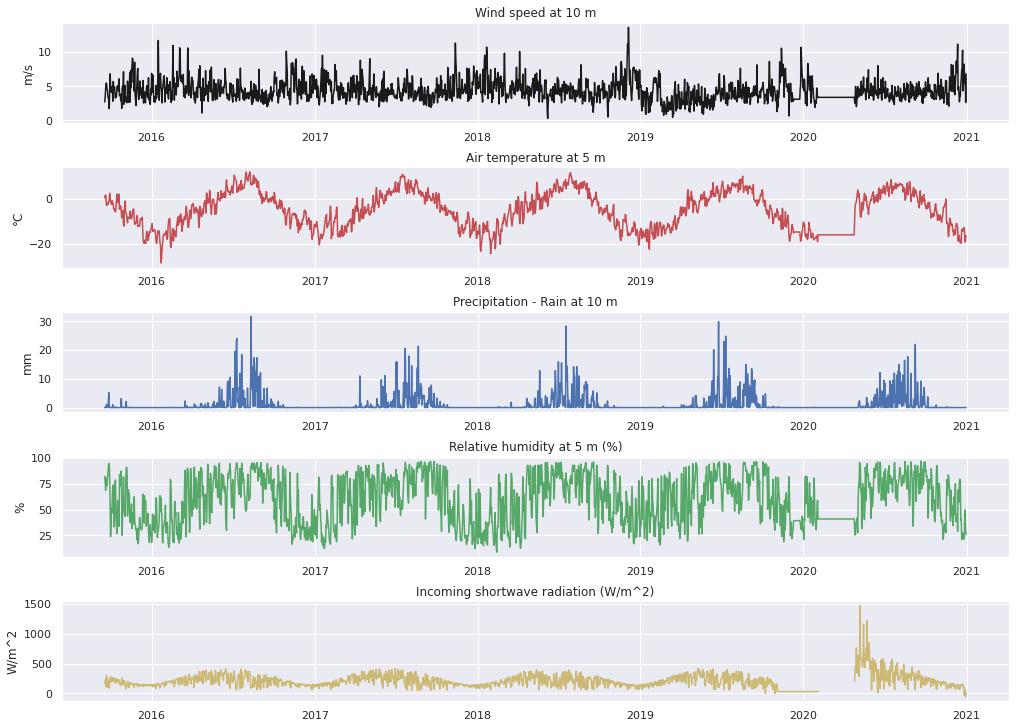

In [13]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=5, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])

f2_ax1.set_title('Wind speed at 10 m')
f2_ax1.plot(data_AWS_syn['Wind speed at 10 m (m/s)'],'k', label='Wind speed at 10 m (m/s)')
f2_ax1.set_ylabel('m/s')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('Air temperature at 5 m')
f2_ax2.plot(data_AWS_syn['Air temperature at 5 m (°C)'], 'r',label='Air temperature at 5 m (°C)')
f2_ax2.set_ylabel('°C')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax2.grid(True)

f2_ax3.set_title('Precipitation - Rain at 10 m')
f2_ax3.plot(data_AWS_prep_dailysum, 'b',label='Precipitation at 10 m (mm)')
f2_ax3.set_ylabel('mm')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax3.grid(True)

f2_ax4.set_title('Relative humidity at 5 m (%)')
f2_ax4.plot(data_AWS_syn['Relative humidity at 5 m (%)'], 'g',label='Relative humidity at 5 m (%)')
f2_ax4.set_ylabel('%')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax4.grid(True)

f2_ax5.set_title('Incoming shortwave radiation (W/m^2)')
f2_ax5.plot(data_AWS_syn['Incoming shortwave radiation (W/m^2)'], 'y',label='Incoming shortwave radiation (W/m^2)')
f2_ax5.set_ylabel('W/m^2')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax5.grid(True)

**Comments:**
* The time period from '2019-12-12':'2019-12-24' and '2020-02':'2020-05' - Should be disregarded since the same values cannot occur at continous time periods
1. Wind speed at 10 m [m/s]
    * Wind speeds vary from 0 : 10.68 m/s with a mean of 3.793 m/s - That seems possible!
    * There is considerable variation - seems plausible.
    * Any chances of seasonality affects? - Westerlies during the winter and Indian Summer Monsoon during the summer.
2. Air temperature at 5 m [°C]
    * Varies from -22.37°C : 9.97°C with a mean of -5°C. - Very cold region!
    * The air temperature increases during the summer and decreases during the winter - Good!
    * Seasonality effects are clearly seen - Good! - Can probably be modelled!
3. Precipitation at 10 m [mm]
    * Variations are quite low! - Varies from 0 : 0.2 mm with a mean of 0.009 mm 
    * The precipitation mainly occurs during the indian summer monsoon period - from June : October
    * There might be more snow than rain
4. Relative humidity at 5 m [%]
    * Varies from 15%: 96% with a mean of 61% - Quite humid most of the time.
    * During precipitation - you see the RH increases - That's good!
    * I was also expecting that the relative humidity decreases with increase in air temperature - Not the case!
5. Incoming shortwave radiation (W/m2)
    * Incoming shortwave radiation: Constant and missing values from 2019-11 : 2020-05. They also have very high unplausible values from 2020-05 onwards.

###  Erroneous data:
* Found two time periods where some the parameters are constant - not possible!
 - (a) '2019-12-12':'2019-12-24'
 - (b) '2020-02':'2020-05'
 - (c) '2019-12-12':'2020-02-05' - For only shortwave radiation
 
* If we are considering to use this dataset, We need to find efficient ways of dealing with erroneous data. To my knowledge, we can consider:
    - (a) Replacing the values with previous year data (Quick-fix)
    - (b) Modelling the datasets using data-driven techniques (Winter-Holt's method, ARIMA, SARIMA, ...etc.)
    - Method (a) is followed! - Or does Dr. Mudelsee have a better idea?

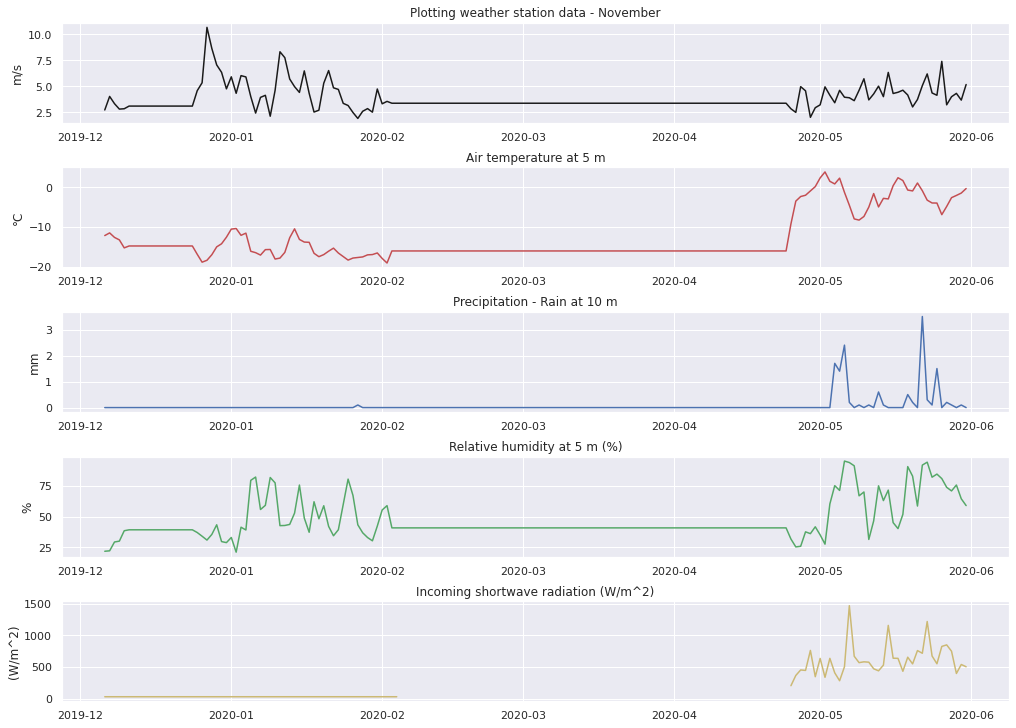

In [14]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=5, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])

data_AWS_syn_plot = data_AWS_syn['2019-12-06':'2020-05']

f2_ax1.set_title('Plotting weather station data - November')
f2_ax1.plot(data_AWS_syn_plot['Wind speed at 10 m (m/s)'],'k', label='Wind speed at 10 m (m/s)')
f2_ax1.set_ylabel('m/s')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('Air temperature at 5 m')
f2_ax2.plot(data_AWS_syn_plot['Air temperature at 5 m (°C)'], 'r',label='Air temperature at 5 m (°C)')
f2_ax2.set_ylabel('°C')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax2.grid(True)

f2_ax3.set_title('Precipitation - Rain at 10 m')
f2_ax3.plot(data_AWS_prep_dailysum['2019-12-06':'2020-05'], 'b',label='Precipitation at 10 m (mm)')
f2_ax3.set_ylabel('mm')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax3.grid(True)

f2_ax4.set_title('Relative humidity at 5 m (%)')
f2_ax4.plot(data_AWS_syn_plot['Relative humidity at 5 m (%)'], 'g',label='Relative humidity at 5 m (%)')
f2_ax4.set_ylabel('%')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax4.grid(True)

f2_ax5.set_title('Incoming shortwave radiation (W/m^2)')
f2_ax5.plot(data_AWS_syn_plot['Incoming shortwave radiation (W/m^2)'], 'y',label='Incoming shortwave radiation (W/m^2)')
f2_ax5.set_ylabel('(W/m^2)')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax5.grid(True)

* Comments:
    - Air temperature at 5 m, Precipitation (rain) at 10 m, and relative humidity all look plausible.
    - Wind speed has erroneous (constant) data close to the end of the year 2020!
    - Incoming shortwave radiation has a constant value from around 2019-11 : 2019-12-31

Take a closer look for missing values and erroneous data!

### Considering the 2016 - 2019 input dataset 
- The input data required for the model are: 
1. incoming shortwave radiation [W m^-2]
2. air temperature [K]
3. relative humidity [-] [To vary from 0 - 1]
4. wind speed [m s^-1]
5. precipitation rain [m s^-1] - precipitation rain is required in [m s^-1]? We have mm/day - Check the outputs of thier dataset!
6. precipitation snow [m SWE s^-1]

In [15]:
### Changing relative humidity from 0 - 1 : Value/100

data_AWS_syn['Relative humidity at 5 m (%)'] = data_AWS_syn['Relative humidity at 5 m (%)']/100

In [16]:
# Taking the data only from 2016 - 2019
data_AWS_syn_input = data_AWS_syn['2016':'2019'][['Incoming shortwave radiation (W/m^2)','Incoming longwave radiation (W/m^2)','Air temperature at 5 m (°C)','Relative humidity at 5 m (%)','Wind speed at 10 m (m/s)','Soil temperature at - 0.00 m (°C)']]
data_AWS_syn_input['Precipitation-daily_sum (mm)'] = data_AWS_prep_dailysum['2016':'2019']

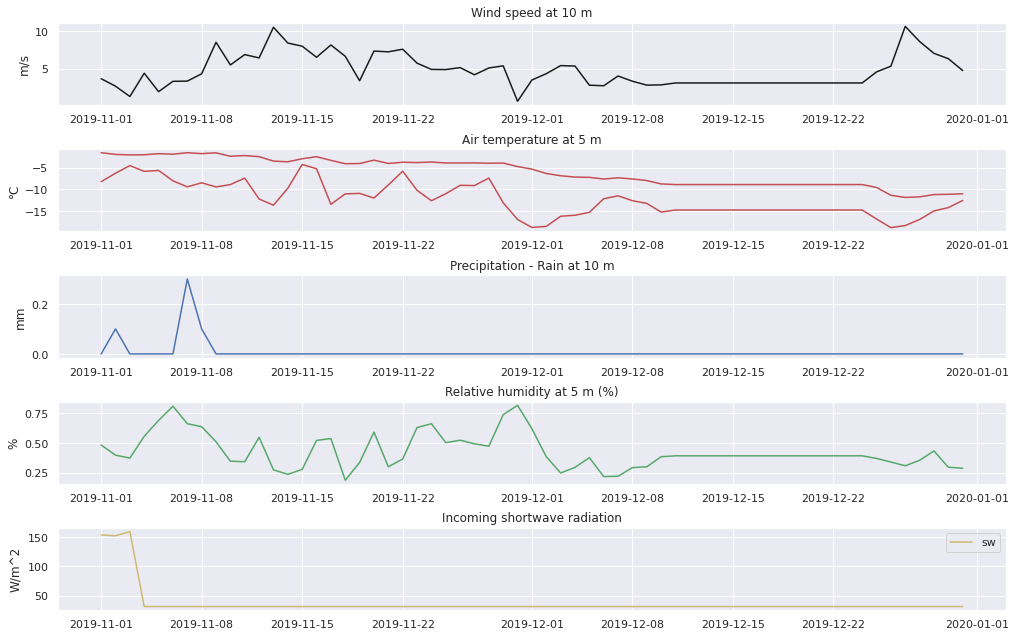

In [17]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=6, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])
#f2_ax6 = fig2.add_subplot(spec2[5, 0])

data_plot = data_AWS_syn_input['2019-11':'2019-12']

f2_ax1.set_title('Wind speed at 10 m')
f2_ax1.plot(data_plot['Wind speed at 10 m (m/s)'],'k', label='Wind speed at 10 m (m/s)')
f2_ax1.set_ylabel('m/s')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('Air temperature at 5 m')
f2_ax2.plot(data_plot['Air temperature at 5 m (°C)'], 'r',label='Air temperature at 5 m (°C)')
f2_ax2.plot(data_plot['Soil temperature at - 0.00 m (°C)'], 'r',label='Soil temperature at - 0.00 m (°C)')
f2_ax2.set_ylabel('°C')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax2.grid(True)

f2_ax3.set_title('Precipitation - Rain at 10 m')
f2_ax3.plot(data_plot['Precipitation-daily_sum (mm)'], 'b',label='Precipitation at 10 m (mm)')
f2_ax3.set_ylabel('mm')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax3.grid(True)

f2_ax4.set_title('Relative humidity at 5 m (%)')
f2_ax4.plot(data_plot['Relative humidity at 5 m (%)'], 'g',label='Relative humidity at 5 m (%)')
f2_ax4.set_ylabel('%')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax4.grid(True)

f2_ax5.set_title('Incoming shortwave radiation')
#f2_ax5.plot(data_AWS_syn_input['Incoming longwave radiation (W/m^2)'], 'k',label='lw')
f2_ax5.plot(data_plot['Incoming shortwave radiation (W/m^2)'], 'y',label='sw')
f2_ax5.set_ylabel('W/m^2')
#f2_ax1.set_xlabel('Date')
f2_ax5.legend()
f2_ax5.grid(True)

#f2_ax6.set_title('Snow depth (in m)')
#f2_ax6.plot(data_AWS_syn_input['Snow depth (in m)'], 'k',label='Snow depth (in m)')
#f2_ax6.set_ylabel('in m')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()

#### Comments:
* Found two time periods where the parameters are constant - not possible!
 - (a) '2019-12-12':'2019-12-24' - For wind speed at 10 m, air temperature at 5 m, relative humidity at 5 m
 - (b) '2019-11':'2020-01' - For incoming shortwave radiation 
 - Dealing with the erroneous (constant) data by replacing it with data from one year earlier

##### How does the data from 2018 look like?

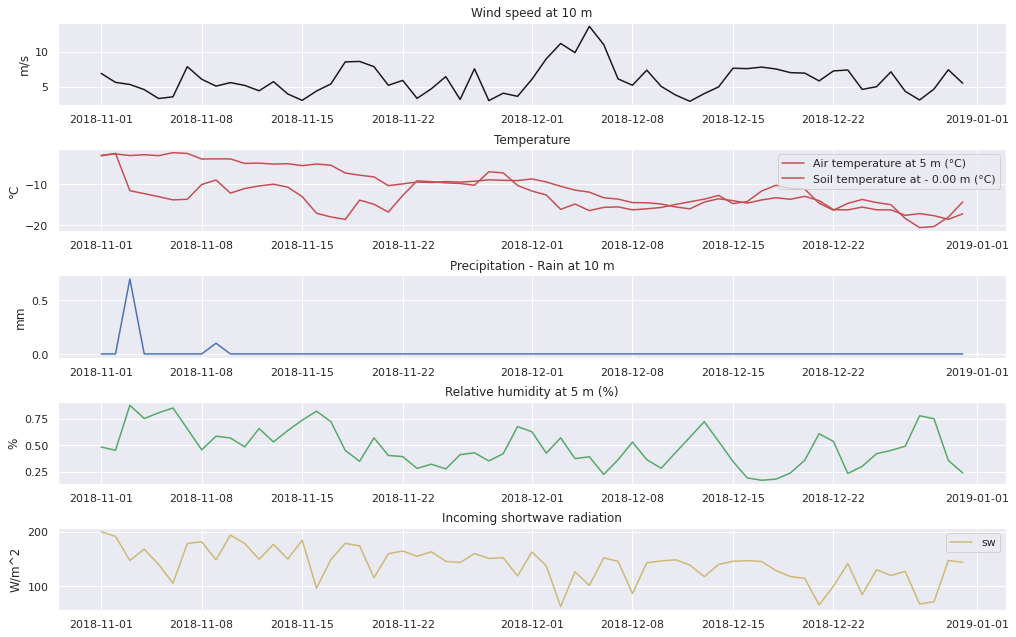

In [18]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=6, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])
#f2_ax6 = fig2.add_subplot(spec2[5, 0])

data_plot = data_AWS_syn_input['2018-11':'2018-12']

f2_ax1.set_title('Wind speed at 10 m')
f2_ax1.plot(data_plot['Wind speed at 10 m (m/s)'],'k', label='Wind speed at 10 m (m/s)')
f2_ax1.set_ylabel('m/s')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('Temperature')
f2_ax2.plot(data_plot['Air temperature at 5 m (°C)'], 'r',label='Air temperature at 5 m (°C)')
f2_ax2.plot(data_plot['Soil temperature at - 0.00 m (°C)'], 'r',label='Soil temperature at - 0.00 m (°C)')
f2_ax2.legend()


f2_ax2.set_ylabel('°C')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax2.grid(True)

f2_ax3.set_title('Precipitation - Rain at 10 m')
f2_ax3.plot(data_plot['Precipitation-daily_sum (mm)'], 'b',label='Precipitation at 10 m (mm)')
f2_ax3.set_ylabel('mm')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax3.grid(True)

f2_ax4.set_title('Relative humidity at 5 m (%)')
f2_ax4.plot(data_plot['Relative humidity at 5 m (%)'], 'g',label='Relative humidity at 5 m (%)')
f2_ax4.set_ylabel('%')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax4.grid(True)

f2_ax5.set_title('Incoming shortwave radiation')
#f2_ax5.plot(data_AWS_syn_input['Incoming longwave radiation (W/m^2)'], 'k',label='lw')
f2_ax5.plot(data_plot['Incoming shortwave radiation (W/m^2)'], 'y',label='sw')
f2_ax5.set_ylabel('W/m^2')
#f2_ax1.set_xlabel('Date')
f2_ax5.legend()
f2_ax5.grid(True)

#f2_ax6.set_title('Snow depth (in m)')
#f2_ax6.plot(data_AWS_syn_input['Snow depth (in m)'], 'k',label='Snow depth (in m)')
#f2_ax6.set_ylabel('in m')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()

#### Plausible values are observed and can be considered to be replaced with erroneous data of 2019
- wind speed at 10 m, subsurface temperature at 0.0 cm, air temperature at 5 m, relative humidity at 5 m : The dataset is replaced from 12-12 : 12-24
- incoming shortwave radiation is replaced from 11-03 : 12-31

In [19]:
# Storing the imputed data in a seperate dataframe
data_AWS_input_imputed = data_AWS_syn_input.copy()

# Wind speed at 10 m (m/s)
data_AWS_input_imputed['Wind speed at 10 m (m/s)']['2019-12-12':'2019-12-24'] = data_AWS_input_imputed['Wind speed at 10 m (m/s)']['2018-12-12':'2018-12-24']

# Subsurface temperature at 0.0 cm
data_AWS_input_imputed['Soil temperature at - 0.00 m (°C)']['2019-12-12':'2019-12-24'] = data_AWS_input_imputed['Soil temperature at - 0.00 m (°C)']['2018-12-12':'2018-12-24']

# Air temperature at 5 m
data_AWS_input_imputed['Air temperature at 5 m (°C)']['2019-12-12':'2019-12-24'] = data_AWS_input_imputed['Air temperature at 5 m (°C)']['2018-12-12':'2018-12-24']

# Relative humidity at 5 m
data_AWS_input_imputed['Relative humidity at 5 m (%)']['2019-12-12':'2019-12-24'] = data_AWS_input_imputed['Relative humidity at 5 m (%)']['2018-12-12':'2018-12-24']

# Shortwave radiation
data_AWS_input_imputed['Incoming shortwave radiation (W/m^2)']['2019-11-02':'2019-12-31'] = data_AWS_input_imputed['Incoming shortwave radiation (W/m^2)']['2018-11-02':'2018-12-31']

#data_AWS_input_imputed[['Wind speed at 10 m (m/s)','Air temperature at 5 m (°C)','Relative humidity at 5 m (%)']]['2019-12-12':'2019-12-24'] = data_AWS_input_imputed[['Wind speed at 10 m (m/s)','Air temperature at 5 m (°C)','Relative humidity at 5 m (%)']]['2018-12-12':'2018-12-24'] 

### Data after imputing with the year 2018

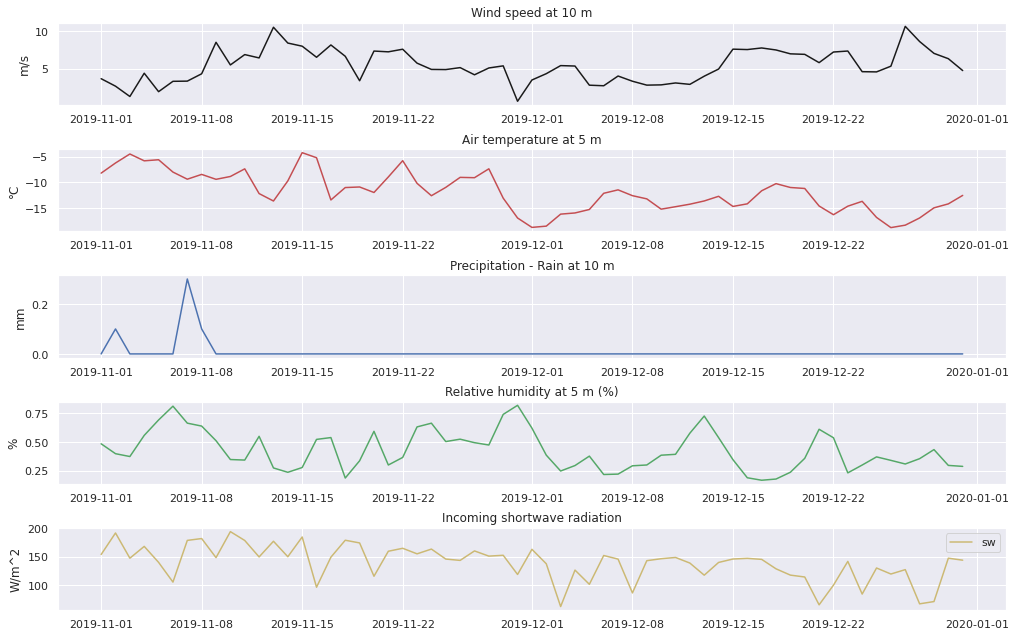

In [20]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=6, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])
#f2_ax6 = fig2.add_subplot(spec2[5, 0])

data_plot = data_AWS_input_imputed['2019-11':'2019-12']

f2_ax1.set_title('Wind speed at 10 m')
f2_ax1.plot(data_plot['Wind speed at 10 m (m/s)'],'k', label='Wind speed at 10 m (m/s)')
f2_ax1.set_ylabel('m/s')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('Air temperature at 5 m')
f2_ax2.plot(data_plot['Air temperature at 5 m (°C)'], 'r',label='Air temperature at 5 m (°C)')
f2_ax2.set_ylabel('°C')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax2.grid(True)

f2_ax3.set_title('Precipitation - Rain at 10 m')
f2_ax3.plot(data_plot['Precipitation-daily_sum (mm)'], 'b',label='Precipitation at 10 m (mm)')
f2_ax3.set_ylabel('mm')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax3.grid(True)

f2_ax4.set_title('Relative humidity at 5 m (%)')
f2_ax4.plot(data_plot['Relative humidity at 5 m (%)'], 'g',label='Relative humidity at 5 m (%)')
f2_ax4.set_ylabel('%')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax4.grid(True)

f2_ax5.set_title('Incoming shortwave radiation')
#f2_ax5.plot(data_AWS_syn_input['Incoming longwave radiation (W/m^2)'], 'k',label='lw')
f2_ax5.plot(data_plot['Incoming shortwave radiation (W/m^2)'], 'y',label='sw')
f2_ax5.set_ylabel('W/m^2')
#f2_ax1.set_xlabel('Date')
f2_ax5.legend()
f2_ax5.grid(True)

#f2_ax6.set_title('Snow depth (in m)')
#f2_ax6.plot(data_AWS_syn_input['Snow depth (in m)'], 'k',label='Snow depth (in m)')
#f2_ax6.set_ylabel('in m')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()

### Looks good!

### Missing data

In [21]:
data_AWS_input_imputed.index[np.where(np.isnan(data_AWS_input_imputed))[0]], len(data_AWS_input_imputed.index[np.where(np.isnan(data_AWS_input_imputed))[0]])

(DatetimeIndex(['2019-10-09', '2019-10-10'], dtype='datetime64[ns]', name='TIMESTAMP', freq=None),
 2)

- Only two missing values are found! - Where are they?

In [22]:
data_AWS_input_imputed['2019-10-09':'2019-10-10']

,Incoming shortwave radiation (W/m^2),Incoming longwave radiation (W/m^2),Air temperature at 5 m (°C),Relative humidity at 5 m (%),Wind speed at 10 m (m/s),Soil temperature at - 0.00 m (°C),Precipitation-daily_sum (mm)
TIMESTAMP,,,,,,,
2019-10-09,108.058007,294.720139,-4.711500,0.942340,NaN,-0.329493,0.1
2019-10-10,158.793778,258.058333,-5.464847,0.932264,NaN,-0.467486,0.0


- Wind speed at 10 m (m/s) has the two missing values - replacing the missing values with previous year!

In [23]:
data_AWS_input_imputed['Wind speed at 10 m (m/s)']['2019-10-09'] = data_AWS_input_imputed['Wind speed at 10 m (m/s)']['2018-10-09']

data_AWS_input_imputed['Wind speed at 10 m (m/s)']['2019-10-10'] = data_AWS_input_imputed['Wind speed at 10 m (m/s)']['2018-10-10']

In [24]:
# Check once more for null values
data_AWS_input_imputed.index[np.where(np.isnan(data_AWS_input_imputed))[0]], len(data_AWS_input_imputed.index[np.where(np.isnan(data_AWS_input_imputed))[0]])

(DatetimeIndex([], dtype='datetime64[ns]', name='TIMESTAMP', freq=None), 0)

In [25]:
data_AWS_input_final = data_AWS_input_imputed.copy()
data_AWS_input_final.head()

,Incoming shortwave radiation (W/m^2),Incoming longwave radiation (W/m^2),Air temperature at 5 m (°C),Relative humidity at 5 m (%),Wind speed at 10 m (m/s),Soil temperature at - 0.00 m (°C),Precipitation-daily_sum (mm)
TIMESTAMP,,,,,,,
2016-01-01,147.702618,143.619444,-11.888438,0.181419,6.880639,-13.103958,0.0
2016-01-02,140.529160,174.365278,-11.031660,0.243579,5.634090,-12.255417,0.0
2016-01-03,135.256493,172.479861,-13.446111,0.456374,4.129521,-12.737500,0.0
2016-01-04,107.868264,174.425694,-14.566944,0.434167,6.604604,-13.006597,0.0
2016-01-05,148.488174,150.390972,-14.099236,0.298974,4.566090,-13.525278,0.0


### Unit conversion
1. incoming shortwave radiation [W m^-2] - remains the same.
2. air temperature and subsurface temperature [K] - From °C --> K [+273.15]
3. relative humidity [-] - remains the same
4. wind speed [m s^-1] - remains the same
5. precipitation rain [m s^-1] - From mm/day --> m/s [/(10^3 * 86400) (or) * 1.1574 X 10^{-8}]
6. precipitation snow [m SWE s^-1] - From m/day --> m/s [/86400]

In [26]:
data_AWS_input_final.columns

Index(['Incoming shortwave radiation (W/m^2)',
       'Incoming longwave radiation (W/m^2)', 'Air temperature at 5 m (°C)',
       'Relative humidity at 5 m (%)', 'Wind speed at 10 m (m/s)',
       'Soil temperature at - 0.00 m (°C)', 'Precipitation-daily_sum (mm)'],
      dtype='object')

In [27]:
#data_AWS_input_final = data_AWS_input_2017.copy()

data_AWS_input_final['Soil temperature at - 0.00 m [K]'] = data_AWS_input_final['Soil temperature at - 0.00 m (°C)'] + 273.15
data_AWS_input_final['air temperature [K]'] = data_AWS_input_final['Air temperature at 5 m (°C)'] + 273.15
data_AWS_input_final['precipitation rain [m s^-1]'] = data_AWS_input_final['Precipitation-daily_sum (mm)']/(1000*86400)

data_AWS_input_final.head()

,Incoming shortwave radiation (W/m^2),Incoming longwave radiation (W/m^2),Air temperature at 5 m (°C),Relative humidity at 5 m (%),Wind speed at 10 m (m/s),Soil temperature at - 0.00 m (°C),Precipitation-daily_sum (mm),Soil temperature at - 0.00 m [K],air temperature [K],precipitation rain [m s^-1]
TIMESTAMP,,,,,,,,,,
2016-01-01,147.702618,143.619444,-11.888438,0.181419,6.880639,-13.103958,0.0,260.046042,261.261562,0.0
2016-01-02,140.529160,174.365278,-11.031660,0.243579,5.634090,-12.255417,0.0,260.894583,262.118340,0.0
2016-01-03,135.256493,172.479861,-13.446111,0.456374,4.129521,-12.737500,0.0,260.412500,259.703889,0.0
2016-01-04,107.868264,174.425694,-14.566944,0.434167,6.604604,-13.006597,0.0,260.143403,258.583056,0.0
2016-01-05,148.488174,150.390972,-14.099236,0.298974,4.566090,-13.525278,0.0,259.624722,259.050764,0.0


### Snow depth

In [28]:
# Snow depth is also a input parameter - data collected from Dr. Xiao's article
Snow_depth = pd.read_excel('Final_data_excelsheet/Yakou_metstation_data_2017_snowdepth.xlsx',sheet_name='snow_depth',index_col=0, parse_dates=True) 
Snow_depth.head()

,Snow depth (m)
Measurement Time,
2017-01-01,0.000375
2017-01-02,0.000208
2017-01-03,0.000125
2017-01-04,0.000458
2017-01-05,0.000250


In [29]:
Snow_depth.index[np.where(np.isnan(Snow_depth))[0]], len(Snow_depth.index[np.where(np.isnan(Snow_depth))[0]])

(DatetimeIndex(['2017-10-20', '2017-10-21', '2017-10-22', '2017-10-23',
                '2017-10-24', '2017-10-25', '2017-10-26', '2017-10-27',
                '2017-10-28', '2017-10-29', '2017-10-30', '2017-10-31',
                '2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
                '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08',
                '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
                '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
                '2017-11-17', '2017-11-18', '2017-11-19', '2017-11-20',
                '2017-11-21', '2017-11-22', '2017-11-23', '2017-11-24'],
               dtype='datetime64[ns]', name='Measurement Time', freq=None),
 36)

* All of the missing values are for snow depth - Totally 36
* What can we do now for these missing values? - The available options are:
    - To replace the value with 0 [Think of a method in the future!] (or are the values too less to be considered seriously?)
    - On observing the data, we can observe relatively constant snow precipitation close to the end of the year. We can replace the missing values with an average of the snow depth data (December 2017).
* Since we do not have snow depth data for the year 2016, 2018, 2019 - I am considering to replicate the snow depth data of the year 2017. - We are still waiting for the data from Shenqi

In [30]:
# Calculating the average snow depth value in December:
np.average(Snow_depth.loc['2017-12'])

0.048606129032258055

In [31]:
# Filling the snow depth missing data with an average value

#data_AWS_input_2017['Snow depth (in m)'] = data_AWS_syn_input['Snow depth (in m)'].fillna(0)

Snow_depth = Snow_depth.fillna(np.average(Snow_depth.loc['2017-12']))

<AxesSubplot:xlabel='Measurement Time'>

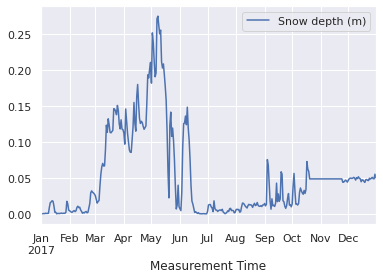

In [32]:
Snow_depth.plot()

In [33]:
Snow_depth

,Snow depth (m)
Measurement Time,
2017-01-01,0.000375
2017-01-02,0.000208
2017-01-03,0.000125
2017-01-04,0.000458
2017-01-05,0.000250
...,...
2017-12-27,0.050770
2017-12-28,0.049060
2017-12-29,0.048640


In [34]:
# Concatatenating all the dataframes for the year 2016, 2017, 2018, 2019.

snow_depth_2016_2019 = np.concatenate([Snow_depth['Snow depth (m)'].values, Snow_depth['Snow depth (m)'].values, Snow_depth['Snow depth (m)'].values, Snow_depth['Snow depth (m)'].values])

# Note: The year 2016 has 366 days, hence I am adding the Dec 31st value once more
snow_depth_2016_2019 = np.insert(snow_depth_2016_2019, 366, Snow_depth['Snow depth (m)']['2017-12-31'])

In [35]:
len(snow_depth_2016_2019)

1461

In [36]:
# Creating a dataframe with four years of snow depth data

# The snow depth dataframe with the same index
Snow_depth_4_yrs = pd.DataFrame(index=data_AWS_input_final.index,data = snow_depth_2016_2019, columns=['Snow depth (m)'])

Snow_depth_4_yrs.head()

,Snow depth (m)
TIMESTAMP,
2016-01-01,0.000375
2016-01-02,0.000208
2016-01-03,0.000125
2016-01-04,0.000458
2016-01-05,0.000250


#### To define the SWE, the following file was considered: http://webarchiv.ethz.ch/arolla/Arolla_Data/SnowConditions/depth_to_swe.pdf
Snow water equivalent is the water content obtained from melting a sample of snow. Density is defined as the ratio of mass per unit volume. Since the mass of the sample is the same whether it is snow or water, the relationship can be expressed using the respective densities and volumes. 

Let $V_{snow}$ = the volume of the snow in the sample, $\rho_{snow}$ = the density of the snow in the sample, V_{water} = the volume of the water when the sample is melted, $\rho_{water}$ = the density of water.

Since the mass of the sample in snow and water remains the same:

$$ m_{water}  = m_{snow}$$

$$ \rho_{water} V_{water} = \rho_{snow} V_{snow} $$

Here, if the Area (A) is constant for both water and snow (it is!), then the $V_{water} = A * SWE$ and $V_{snow} = A * Z_s$ where SWE is the snow water equivalent, $Z_s$ is the depth of snow. We can now write the equation as

$$ \rho_{water} * A * SWE = \rho_{snow} * A * Z_s$$

Finally we have the equation:

$$  SWE = \frac{\rho_{snow} * Z_s}{\rho_{water}} $$

Here we also need the SWE in $m s^{-1}$ --> $Z_s$ is in m/day. $\rho_{water} = 1000 \frac{kg}{m^3}$, $\rho_{snow} = 1000 \frac{kg}{m^3}$. 

Based on the link - https://www.sciencelearn.org.nz/resources/1391-snow-and-ice-density, and Atchley article 2015. Assuming a average snow density between 50 - 1000 $\frac{kg}{m^3}$

Ex: $$ SWE (m s^{-1}) = \frac{450 * Z_s}{1000*86400} = 5.208E-06 * Z_s $$

In [37]:
Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.45'] = Snow_depth_4_yrs['Snow depth (m)']*(0.45/86400)
Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.2'] = Snow_depth_4_yrs['Snow depth (m)']*(0.2/86400)
Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.1'] = Snow_depth_4_yrs['Snow depth (m)']*(0.1/86400)
Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.04'] = Snow_depth_4_yrs['Snow depth (m)']*(0.04/86400)
Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.01'] = Snow_depth_4_yrs['Snow depth (m)']*(0.01/86400)

In [38]:
### Adding the Snow depth data to the dataframe:
data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.45'] = Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.45']
data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.2'] = Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.2']
data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.1'] = Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.1']
data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.04'] = Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.04']
data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.01'] = Snow_depth_4_yrs['precipitation snow [m SWE s^-1]_sd0.01']
data_AWS_input_final.head()

,Incoming shortwave radiation (W/m^2),Incoming longwave radiation (W/m^2),Air temperature at 5 m (°C),Relative humidity at 5 m (%),Wind speed at 10 m (m/s),Soil temperature at - 0.00 m (°C),Precipitation-daily_sum (mm),Soil temperature at - 0.00 m [K],air temperature [K],precipitation rain [m s^-1],precipitation snow [m SWE s^-1]_sd0.45,precipitation snow [m SWE s^-1]_sd0.2,precipitation snow [m SWE s^-1]_sd0.1,precipitation snow [m SWE s^-1]_sd0.04,precipitation snow [m SWE s^-1]_sd0.01
TIMESTAMP,,,,,,,,,,,,,,,
2016-01-01,147.702618,143.619444,-11.888438,0.181419,6.880639,-13.103958,0.0,260.046042,261.261562,0.0,1.953125e-09,8.680556e-10,4.340278e-10,1.736111e-10,4.340278e-11
2016-01-02,140.529160,174.365278,-11.031660,0.243579,5.634090,-12.255417,0.0,260.894583,262.118340,0.0,1.085068e-09,4.822523e-10,2.411262e-10,9.645046e-11,2.411262e-11
2016-01-03,135.256493,172.479861,-13.446111,0.456374,4.129521,-12.737500,0.0,260.412500,259.703889,0.0,6.510417e-10,2.893519e-10,1.446759e-10,5.787037e-11,1.446759e-11
2016-01-04,107.868264,174.425694,-14.566944,0.434167,6.604604,-13.006597,0.0,260.143403,258.583056,0.0,2.387151e-09,1.060956e-09,5.304780e-10,2.121912e-10,5.304780e-11
2016-01-05,148.488174,150.390972,-14.099236,0.298974,4.566090,-13.525278,0.0,259.624722,259.050764,0.0,1.302083e-09,5.787037e-10,2.893519e-10,1.157407e-10,2.893519e-11


In [39]:
data_AWS_input_final.index = pd.to_datetime(data_AWS_input_final.index)

### Final plot that will serve as input into the model:

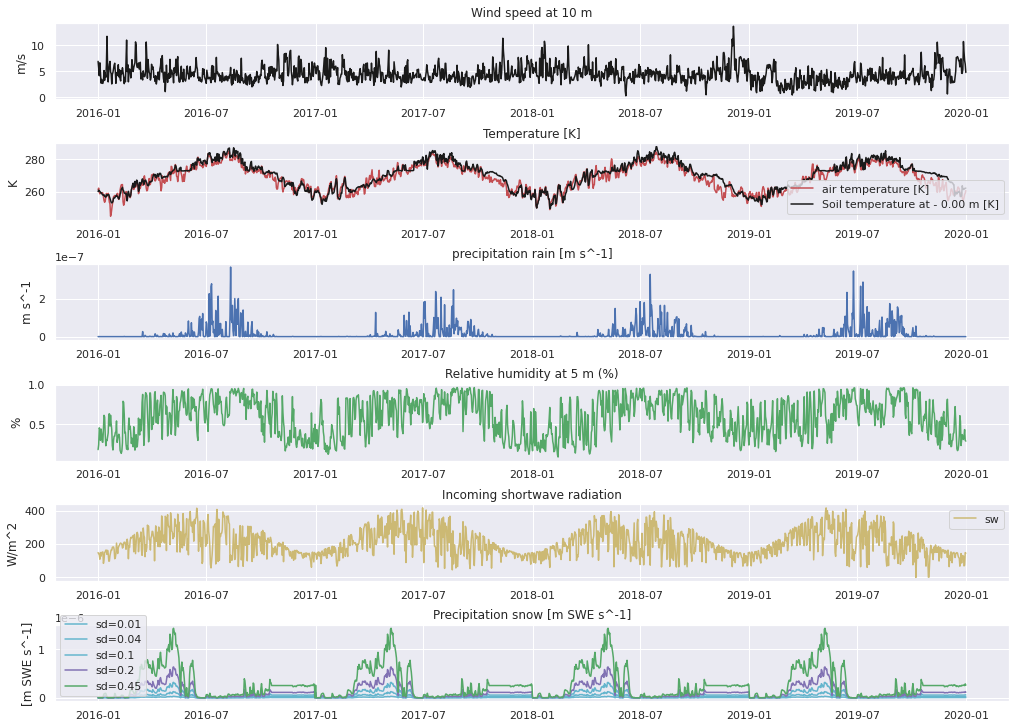

In [40]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=6, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])
f2_ax6 = fig2.add_subplot(spec2[5, 0])

f2_ax1.set_title('Wind speed at 10 m')
f2_ax1.plot(data_AWS_input_final['Wind speed at 10 m (m/s)'],'k', label='Wind speed at 10 m (m/s)')
f2_ax1.set_ylabel('m/s')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('Temperature [K]')
f2_ax2.plot(data_AWS_input_final['air temperature [K]'], 'r',label='air temperature [K]')
f2_ax2.plot(data_AWS_input_final['Soil temperature at - 0.00 m [K]'], 'k',label='Soil temperature at - 0.00 m [K]')
f2_ax2.set_ylabel('K')
#f2_ax1.set_xlabel('Date')
f2_ax2.legend()
f2_ax2.grid(True)

f2_ax3.set_title('precipitation rain [m s^-1]')
f2_ax3.plot(data_AWS_input_final['precipitation rain [m s^-1]'], 'b',label='precipitation rain [m s^-1]')
f2_ax3.set_ylabel('m s^-1')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax3.grid(True)

f2_ax4.set_title('Relative humidity at 5 m (%)')
f2_ax4.plot(data_AWS_input_final['Relative humidity at 5 m (%)'], 'g',label='Relative humidity at 5 m (%)')
f2_ax4.set_ylabel('%')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax4.grid(True)

f2_ax5.set_title('Incoming shortwave radiation')
#f2_ax5.plot(data_AWS_input_final['Incoming longwave radiation (W/m^2)'], 'k',label='lw')
f2_ax5.plot(data_AWS_input_final['Incoming shortwave radiation (W/m^2)'], 'y',label='sw')
f2_ax5.set_ylabel('W/m^2')
#f2_ax1.set_xlabel('Date')
f2_ax5.legend()
f2_ax5.grid(True)

f2_ax6.set_title('Precipitation snow [m SWE s^-1]')
#f2_ax5.plot(data_AWS_input_final['Incoming longwave radiation (W/m^2)'], 'k',label='lw')
f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.01'], 'c',label='sd=0.01')
f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.04'], 'c',label='sd=0.04')
f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.1'], 'c',label='sd=0.1')
f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.2'], 'm',label='sd=0.2')
f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.45'], 'g',label='sd=0.45')
f2_ax6.set_ylabel('[m SWE s^-1]')
#f2_ax1.set_xlabel('Date')
f2_ax6.legend()
f2_ax6.grid(True)


In [41]:
data_AWS_input_final = data_AWS_input_final[['air temperature [K]','Soil temperature at - 0.00 m [K]','Wind speed at 10 m (m/s)','precipitation rain [m s^-1]','Relative humidity at 5 m (%)','Incoming shortwave radiation (W/m^2)','precipitation snow [m SWE s^-1]_sd0.1','precipitation snow [m SWE s^-1]_sd0.2','precipitation snow [m SWE s^-1]_sd0.45','precipitation snow [m SWE s^-1]_sd0.04','precipitation snow [m SWE s^-1]_sd0.01']]
data_AWS_input_final.head()

,air temperature [K],Soil temperature at - 0.00 m [K],Wind speed at 10 m (m/s),precipitation rain [m s^-1],Relative humidity at 5 m (%),Incoming shortwave radiation (W/m^2),precipitation snow [m SWE s^-1]_sd0.1,precipitation snow [m SWE s^-1]_sd0.2,precipitation snow [m SWE s^-1]_sd0.45,precipitation snow [m SWE s^-1]_sd0.04,precipitation snow [m SWE s^-1]_sd0.01
TIMESTAMP,,,,,,,,,,,
2016-01-01,261.261562,260.046042,6.880639,0.0,0.181419,147.702618,4.340278e-10,8.680556e-10,1.953125e-09,1.736111e-10,4.340278e-11
2016-01-02,262.118340,260.894583,5.634090,0.0,0.243579,140.529160,2.411262e-10,4.822523e-10,1.085068e-09,9.645046e-11,2.411262e-11
2016-01-03,259.703889,260.412500,4.129521,0.0,0.456374,135.256493,1.446759e-10,2.893519e-10,6.510417e-10,5.787037e-11,1.446759e-11
2016-01-04,258.583056,260.143403,6.604604,0.0,0.434167,107.868264,5.304780e-10,1.060956e-09,2.387151e-09,2.121912e-10,5.304780e-11
2016-01-05,259.050764,259.624722,4.566090,0.0,0.298974,148.488174,2.893519e-10,5.787037e-10,1.302083e-09,1.157407e-10,2.893519e-11


### Calibration dataset - 2016 - 2018

In [42]:
# Storing the data in a seperate dataframe
data_AWS_input_calib = data_AWS_input_final['2016':'2018']

In [43]:
# Opening the input file
hf_input = h5py.File('Final_InputData_4yrs/Calib_data_2016_2018.h5','w')

In [44]:
len(data_AWS_input_calib)

1096

In [45]:
# Creating a variable with time instances for 1096 days
no_days = len(data_AWS_input_calib) # Total number of days
no_secs_day = 86400 # Total number of seconds in a day
times = np.arange(0,no_days*no_secs_day,no_secs_day)
len(times)

1096

In [46]:
data_AWS_input_calib.columns

Index(['air temperature [K]', 'Soil temperature at - 0.00 m [K]',
       'Wind speed at 10 m (m/s)', 'precipitation rain [m s^-1]',
       'Relative humidity at 5 m (%)', 'Incoming shortwave radiation (W/m^2)',
       'precipitation snow [m SWE s^-1]_sd0.1',
       'precipitation snow [m SWE s^-1]_sd0.2',
       'precipitation snow [m SWE s^-1]_sd0.45',
       'precipitation snow [m SWE s^-1]_sd0.04',
       'precipitation snow [m SWE s^-1]_sd0.01'],
      dtype='object')

In [47]:
# Changing the storage to numpy array
hf_input.create_dataset('time [s]', data=times)
hf_input.create_dataset('Soil temperature at - 0.00 m [K]', data=data_AWS_input_calib['Soil temperature at - 0.00 m [K]'].values)
hf_input.create_dataset('air temperature [K]', data=data_AWS_input_calib['air temperature [K]'].values)
hf_input.create_dataset('Wind speed at 10 m (m/s)', data=data_AWS_input_calib['Wind speed at 10 m (m/s)'].values)
hf_input.create_dataset('precipitation rain [m s^-1]', data=data_AWS_input_calib['precipitation rain [m s^-1]'].values)
hf_input.create_dataset('Relative humidity at 5 m (%)', data=data_AWS_input_calib['Relative humidity at 5 m (%)'].values)
hf_input.create_dataset('Incoming shortwave radiation (W/m^2)', data=data_AWS_input_calib['Incoming shortwave radiation (W/m^2)'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.1', data=data_AWS_input_calib['precipitation snow [m SWE s^-1]_sd0.1'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.2', data=data_AWS_input_calib['precipitation snow [m SWE s^-1]_sd0.2'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.45', data=data_AWS_input_calib['precipitation snow [m SWE s^-1]_sd0.45'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.04', data=data_AWS_input_calib['precipitation snow [m SWE s^-1]_sd0.04'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.01', data=data_AWS_input_calib['precipitation snow [m SWE s^-1]_sd0.01'].values)

<HDF5 dataset "precipitation snow [m SWE s^-1]_sd0.01": shape (1096,), type "<f8">

In [48]:
hf_input.close()

In [49]:
### Reading the file once more to check
### Extracting the data from the example 'column_data.h5'.  
with h5py.File(f'Final_InputData_4yrs/Calib_data_2016_2018.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    print(np.array(hdf.get('air temperature [K]')))
    print(len(np.array(hdf.get('air temperature [K]'))))

    #temperature_column = np.array(hdf.get('temperature.cell.0/1600'))

List of datasets in this file: 
 
 ['Incoming shortwave radiation (W', 'Relative humidity at 5 m (%)', 'Soil temperature at - 0.00 m [K]', 'Wind speed at 10 m (m', 'air temperature [K]', 'precipitation rain [m s^-1]', 'precipitation snow [m SWE s^-1]_sd0.01', 'precipitation snow [m SWE s^-1]_sd0.04', 'precipitation snow [m SWE s^-1]_sd0.1', 'precipitation snow [m SWE s^-1]_sd0.2', 'precipitation snow [m SWE s^-1]_sd0.45', 'time [s]']


[261.2615625  262.11834028 259.70388889 ... 252.8775     255.18458333
 258.84167832]
1096


### Validation dataset - 2019

In [50]:
# Storing the data in a seperate dataframe
data_AWS_input_valid = data_AWS_input_final.loc['2019']

In [51]:
# Opening the input file
hf_input = h5py.File('Final_InputData_4yrs/Validation_data_2019.h5','w')

In [52]:
len(data_AWS_input_valid)

365

In [53]:
# Creating a variable with time instances for 1096 days
no_days = len(data_AWS_input_valid) # Total number of days
no_secs_day = 86400 # Total number of seconds in a day
times = np.arange(0,no_days*no_secs_day,no_secs_day)
len(times)

365

In [54]:
data_AWS_input_valid.columns

Index(['air temperature [K]', 'Soil temperature at - 0.00 m [K]',
       'Wind speed at 10 m (m/s)', 'precipitation rain [m s^-1]',
       'Relative humidity at 5 m (%)', 'Incoming shortwave radiation (W/m^2)',
       'precipitation snow [m SWE s^-1]_sd0.1',
       'precipitation snow [m SWE s^-1]_sd0.2',
       'precipitation snow [m SWE s^-1]_sd0.45',
       'precipitation snow [m SWE s^-1]_sd0.04',
       'precipitation snow [m SWE s^-1]_sd0.01'],
      dtype='object')

In [55]:
# Changing the storage to numpy array
hf_input.create_dataset('time [s]', data=times)
hf_input.create_dataset('Soil temperature at - 0.00 m [K]', data=data_AWS_input_valid['Soil temperature at - 0.00 m [K]'].values)
hf_input.create_dataset('air temperature [K]', data=data_AWS_input_valid['air temperature [K]'].values)
hf_input.create_dataset('Wind speed at 10 m (m/s)', data=data_AWS_input_valid['Wind speed at 10 m (m/s)'].values)
hf_input.create_dataset('precipitation rain [m s^-1]', data=data_AWS_input_valid['precipitation rain [m s^-1]'].values)
hf_input.create_dataset('Relative humidity at 5 m (%)', data=data_AWS_input_valid['Relative humidity at 5 m (%)'].values)
hf_input.create_dataset('Incoming shortwave radiation (W/m^2)', data=data_AWS_input_valid['Incoming shortwave radiation (W/m^2)'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.1', data=data_AWS_input_valid['precipitation snow [m SWE s^-1]_sd0.1'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.2', data=data_AWS_input_valid['precipitation snow [m SWE s^-1]_sd0.2'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.45', data=data_AWS_input_valid['precipitation snow [m SWE s^-1]_sd0.45'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.04', data=data_AWS_input_calib['precipitation snow [m SWE s^-1]_sd0.04'].values)
hf_input.create_dataset('precipitation snow [m SWE s^-1]_sd0.01', data=data_AWS_input_calib['precipitation snow [m SWE s^-1]_sd0.01'].values)

<HDF5 dataset "precipitation snow [m SWE s^-1]_sd0.01": shape (1096,), type "<f8">

In [56]:
hf_input.close()

In [57]:
### Reading the file once more to check
### Extracting the data from the example 'column_data.h5'.  
with h5py.File(f'Final_InputData_4yrs/Validation_data_2019.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    print(np.array(hdf.get('precipitation snow [m SWE s^-1]_sd0.04')))
    print(len(np.array(hdf.get('air temperature [K]'))))

    #temperature_column = np.array(hdf.get('temperature.cell.0/1600'))

List of datasets in this file: 
 
 ['Incoming shortwave radiation (W', 'Relative humidity at 5 m (%)', 'Soil temperature at - 0.00 m [K]', 'Wind speed at 10 m (m', 'air temperature [K]', 'precipitation rain [m s^-1]', 'precipitation snow [m SWE s^-1]_sd0.01', 'precipitation snow [m SWE s^-1]_sd0.04', 'precipitation snow [m SWE s^-1]_sd0.1', 'precipitation snow [m SWE s^-1]_sd0.2', 'precipitation snow [m SWE s^-1]_sd0.45', 'time [s]']


[1.73611111e-10 9.64504630e-11 5.78703704e-11 ... 2.25185185e-08
 2.55231481e-08 2.31851852e-08]
365


## Preparing the output dataset (calibration and validation)

In [58]:
# Storing the parameter names
output_param_names = ['Soil moisture at - 0.04 m (%)','Soil moisture at - 0.1 m (%)','Soil moisture at - 0.2 m (%)','Soil moisture at - 0.4 m (%)','Soil moisture at - 0.8 m (%)','Soil moisture at - 1.2 m (%)','Soil moisture at - 1.6 m (%)','Soil temperature at - 0.00 m (°C)','Soil temperature at - 0.04 m (°C)','Soil temperature at - 0.1 m (°C)','Soil temperature at - 0.2 m (°C)','Soil temperature at - 0.4 m (°C)','Soil temperature at - 0.8 m (°C)','Soil temperature at - 1.2 m (°C)','Soil temperature at - 1.6 m (°C)']
output_param_names

['Soil moisture at - 0.04 m (%)',
 'Soil moisture at - 0.1 m (%)',
 'Soil moisture at - 0.2 m (%)',
 'Soil moisture at - 0.4 m (%)',
 'Soil moisture at - 0.8 m (%)',
 'Soil moisture at - 1.2 m (%)',
 'Soil moisture at - 1.6 m (%)',
 'Soil temperature at - 0.00 m (°C)',
 'Soil temperature at - 0.04 m (°C)',
 'Soil temperature at - 0.1 m (°C)',
 'Soil temperature at - 0.2 m (°C)',
 'Soil temperature at - 0.4 m (°C)',
 'Soil temperature at - 0.8 m (°C)',
 'Soil temperature at - 1.2 m (°C)',
 'Soil temperature at - 1.6 m (°C)']

In [59]:
data_AWS_output = data_AWS_syn['2016':'2019'][output_param_names].copy()

### Plotting soil moisture at different depths 

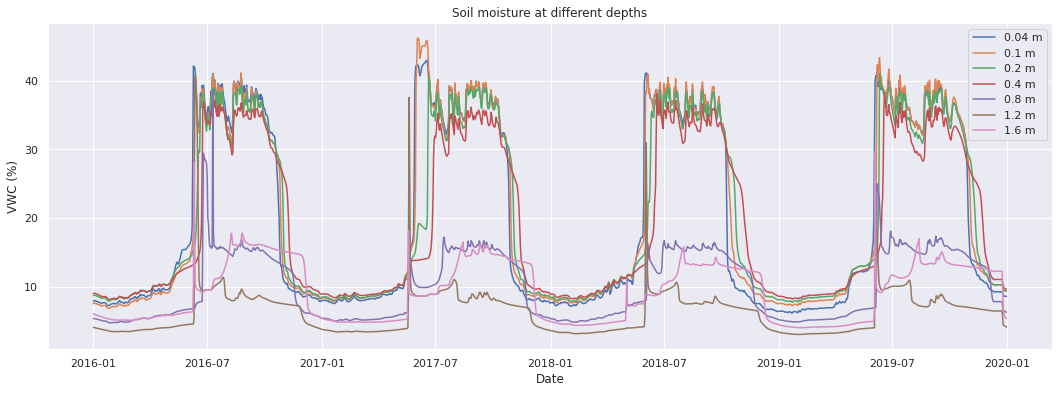

In [60]:
plt.figure(figsize=(18,6))
plt.title('Soil moisture at different depths')
plt.plot(data_AWS_output['Soil moisture at - 0.04 m (%)'], label='0.04 m')
plt.plot(data_AWS_output['Soil moisture at - 0.1 m (%)'], label='0.1 m')
plt.plot(data_AWS_output['Soil moisture at - 0.2 m (%)'], label='0.2 m')
plt.plot(data_AWS_output['Soil moisture at - 0.4 m (%)'], label='0.4 m')
plt.plot(data_AWS_output['Soil moisture at - 0.8 m (%)'], label='0.8 m')
plt.plot(data_AWS_output['Soil moisture at - 1.2 m (%)'], label='1.2 m')
plt.plot(data_AWS_output['Soil moisture at - 1.6 m (%)'], label='1.6 m')


plt.ylabel('VWC (%)')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlabel('Date')
plt.legend()
plt.grid(True)

Comments:
1. Soil moisture decreases with depth - Good!
2. Soil moisture sensors at 0.04 m, 0.1 m, 0.2 m & 0.4 m have similar moisture contents [during the monsoon period] and also higher soil moisture content than at 0.8 m, 1.2 m and 1.6 m. 
3. There seems to be a grouping of soil moisture sensors at 0.04 m, 0.1 m, 0.2 m & 0.4 m  & 0.8 m, 1.2 m and 1.6 m - There probably exist two different layers of soil? - Similar pattern seen at up-slope, middle-slope and riparian zone.
4. Soil moisture content increases during the indian summer monsoons [2019-06 to 2019-11] - Plot it with precipitation?
5. How to identify if soil is frozen? - Seems to be a constant moisture content during the winter period.
6. On observing the yearly trend, the soil moisture content values have more or less similar trends.

### Plotting soil temperature at different depths

In [61]:
df_AWS.columns

Index(['WS_10m', 'WD_10m', 'Ta_5m', 'RH_5m', 'Rain', 'Press', 'IRT_1', 'IRT_2',
       'PAR_down', 'PAR_up', 'DR', 'UR', 'DLR_Cor', 'ULR_Cor', 'Rn', 'Gs_1',
       'Gs_2', 'Gs_3', 'Ms_4cm', 'Ms_10cm', 'Ms_20cm', 'Ms_40cm', 'Ms_80cm',
       'Ms_120cm', 'Ms_160cm', 'Ts_0cm', 'Ts_4cm', 'Ts_10cm', 'Ts_20cm',
       'Ts_40cm', 'Ts_80cm', 'Ts_120cm', 'Ts_160cm'],
      dtype='object')

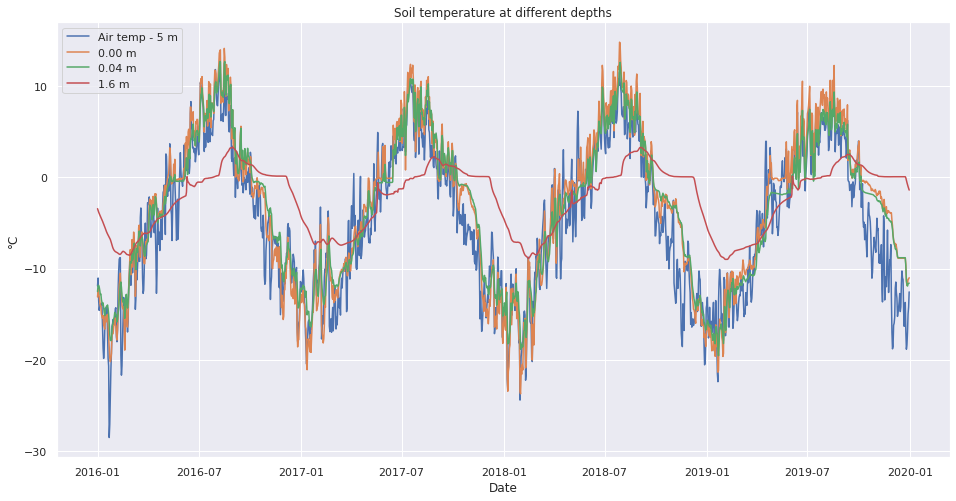

In [62]:
plt.figure(figsize=(16,8))
plt.title('Soil temperature at different depths')
#plt.plot(data_AWS_syn['Air temperature at 5 m (°C)'], label='Air temperature at 5 m')

plt.plot(data_AWS_input_final['air temperature [K]'] -273.15, label='Air temp - 5 m')
plt.plot(data_AWS_output['Soil temperature at - 0.00 m (°C)'], label='0.00 m')
plt.plot(data_AWS_output['Soil temperature at - 0.04 m (°C)'], label='0.04 m')
#plt.plot(data_AWS_output['Soil temperature at - 0.2 m (°C)'], label='0.2 m')
#plt.plot(data_AWS_output['Soil temperature at - 0.4 m (°C)'], label='0.4 m')
#plt.plot(data_AWS_output['Soil temperature at - 0.8 m (°C)'], label='0.8 m')
#plt.plot(data_AWS_output['Soil temperature at - 1.2 m (°C)'], label='1.2 m')
plt.plot(data_AWS_output['Soil temperature at - 1.6 m (°C)'], label='1.6 m')
plt.ylabel('°C')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('°Cm-°Cd'))
plt.xlabel('Date')
plt.legend()
plt.grid(True)

Comments:
1. In the winter the surface is cooler than the subsurface (soil at greater depths) & in the summer, the subsurface is cooler than the surface - Good! 
2. The temperature values increases during the summer and decreases during the winter good!
3. The variations of subsurface temperature decreases with depth.
4. On observing the yearly trend, the temperature variations along different depths seem to be similar.

### Plotting soil temperature, soil moisture, and snow depth

<ipython-input-63-8add4c78b86d>:16: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  f2_ax1.plot(data_AWS_input_final['2017']['precipitation snow [m SWE s^-1]_sd0.45'], 'g',label='sd=0.45')
<ipython-input-63-8add4c78b86d>:24: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  f2_ax2.plot(data_AWS_input_final['2017']['air temperature [K]'] -273.15, label='Air temp - 5 m')
<ipython-input-63-8add4c78b86d>:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  f2_ax2.plot(data_AWS_output['2017']['Soil tem

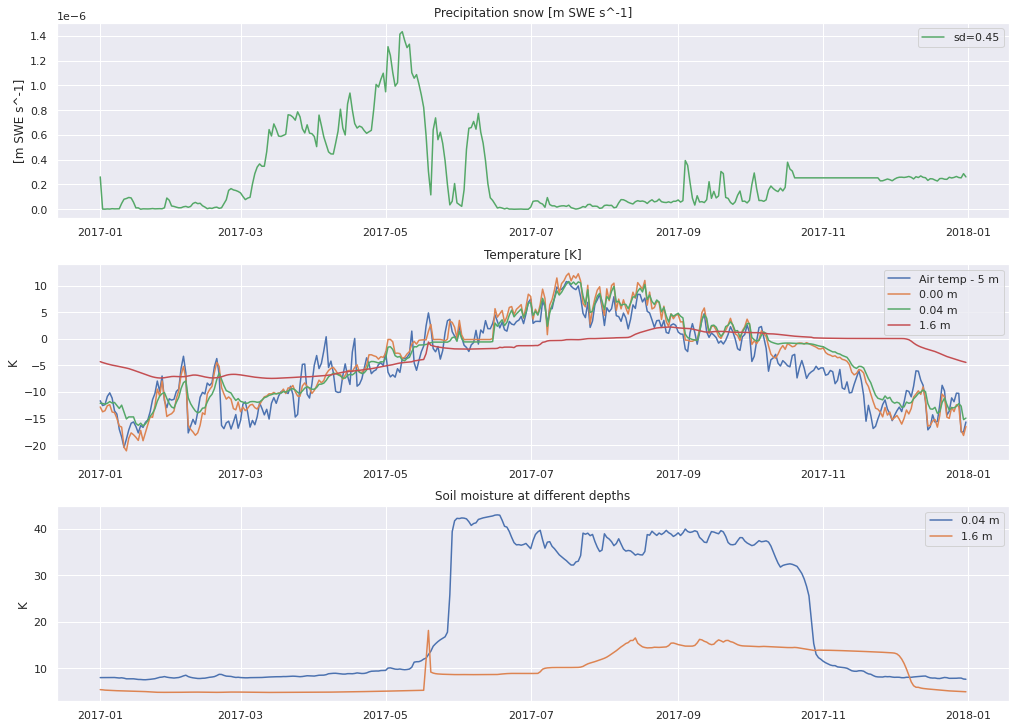

In [63]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
#f2_ax4 = fig2.add_subplot(spec2[3, 0])
#f2_ax5 = fig2.add_subplot(spec2[4, 0])
#f2_ax6 = fig2.add_subplot(spec2[5, 0])

f2_ax1.set_title('Precipitation snow [m SWE s^-1]')
#f2_ax5.plot(data_AWS_input_final['Incoming longwave radiation (W/m^2)'], 'k',label='lw')
#f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.01'], 'c',label='sd=0.01')
#f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.04'], 'c',label='sd=0.04')
#f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.1'], 'c',label='sd=0.1')
#f2_ax6.plot(data_AWS_input_final['precipitation snow [m SWE s^-1]_sd0.2'], 'm',label='sd=0.2')
f2_ax1.plot(data_AWS_input_final['2017']['precipitation snow [m SWE s^-1]_sd0.45'], 'g',label='sd=0.45')
f2_ax1.set_ylabel('[m SWE s^-1]')
#f2_ax1.set_xlabel('Date')
f2_ax1.legend()
f2_ax1.grid(True)


f2_ax2.set_title('Temperature [K]')
f2_ax2.plot(data_AWS_input_final['2017']['air temperature [K]'] -273.15, label='Air temp - 5 m')
f2_ax2.plot(data_AWS_output['2017']['Soil temperature at - 0.00 m (°C)'], label='0.00 m')
f2_ax2.plot(data_AWS_output['2017']['Soil temperature at - 0.04 m (°C)'], label='0.04 m')
#plt.plot(data_AWS_output['Soil temperature at - 0.2 m (°C)'], label='0.2 m')
#plt.plot(data_AWS_output['Soil temperature at - 0.4 m (°C)'], label='0.4 m')
#plt.plot(data_AWS_output['Soil temperature at - 0.8 m (°C)'], label='0.8 m')
#plt.plot(data_AWS_output['Soil temperature at - 1.2 m (°C)'], label='1.2 m')
f2_ax2.plot(data_AWS_output['2017']['Soil temperature at - 1.6 m (°C)'], label='1.6 m')
f2_ax2.set_ylabel('K')
#f2_ax1.set_xlabel('Date')
f2_ax2.legend()
f2_ax2.grid(True)

f2_ax3.set_title('Soil moisture at different depths')
f2_ax3.plot(data_AWS_output['2017']['Soil moisture at - 0.04 m (%)'], label='0.04 m')
#f2_ax3.plot(data_AWS_output['2017']['Soil moisture at - 0.1 m (%)'], label='0.1 m')
#f2_ax3.plot(data_AWS_output['2017']['Soil moisture at - 0.2 m (%)'], label='0.2 m')
#f2_ax3.plot(data_AWS_output['2017']['Soil moisture at - 0.4 m (%)'], label='0.4 m')
#f2_ax3.plot(data_AWS_output['2017']['Soil moisture at - 0.8 m (%)'], label='0.8 m')
#f2_ax3.plot(data_AWS_output['2017']['Soil moisture at - 1.2 m (%)'], label='1.2 m')
f2_ax3.plot(data_AWS_output['2017']['Soil moisture at - 1.6 m (%)'], label='1.6 m')
f2_ax3.set_ylabel('K')
#f2_ax1.set_xlabel('Date')
f2_ax3.legend()
f2_ax3.grid(True)





### Dealing with Erroneous and missing data data:

In [64]:
data_AWS_output.index[np.where(np.isnan(data_AWS_output))[0]]

DatetimeIndex([], dtype='datetime64[ns]', name='TIMESTAMP', freq=None)

### No missing or erroneous values??!!

In [65]:
data_AWS_output_calib = data_AWS_output.loc['2016':'2018']
data_AWS_output_validate = data_AWS_output.loc['2019']

#### Storing the data in a csv file for calibration (pest)

In [66]:
data_AWS_output_calib.to_csv('Final_OutputData_4yrs/Calib_outputdata_2016_2018.csv', sep='\t')
data_AWS_output_validate.to_csv('Final_OutputData_4yrs/Validate_outputdata_2019.csv', sep='\t')